# Modeling implicit bias with Fuzzy Cognitive Maps

In this tutorial, we will implement an FCM-based model to quantify implicit bias in structured classification datasets where features can be numeric or discrete. In this model, features are mapped to neural concepts that are initially activated by experts when running what-if simulations, whereas weights connecting the neural concepts represent absolute correlation/association patterns between features. In addition, we introduce a new reasoning mechanism equipped with a normalization-like transfer function that prevents neurons from saturating. Another advantage of this new reasoning mechanism is that it can be controlled by regulating nonlinearity when updating neurons' activation values in each iteration.

In [1]:
import sys
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=2.5, rc=paper_rc)
                   
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Fuzzy Cognitive Maps

Fuzzy Cognitive Maps (FCMs) are recurrent neural networks consisting of concepts and signed weighted connections. These knowledge-based reasoning models allow modeling complex systems in terms of causal relationships and well-defined concepts. Neural concepts represent variables, states, and entities related to the physical system under investigation. The signed weight associated with each edge denotes the causality strength (or degree of correlation or association if deemed appropiated) between the neurons. Weights can be quantified in the $[-1, 1]$ interval, while that neuron's activation values can take values in either $[0,1]$ or $[-1, 1]$ depending on the nonlinear transfer function attached to each neuron.

In each iteration, an FCM model produces an activation vector $A_k^{(t)}=[a_{k1}^{(t)}, \ldots, a_{ki}^{(t)}, \ldots, a_{kM}^{(t)}]$ where $a_{ki}^{(t)}$ is the activation value of the $i$-th neural entity in the $t$-th iteration, given the $k$-th initial stimulus. The following equation displays the recurrent reasoning rule of this model,

$A_k^{(t)} = f \left(A_k^{(t-1)}W \right)$

where $M$ denotes the number of neurons and $W_{M \times M}$ is the weight matrix such that $w_{ji}$ represents the weight connecting the $C_j$ and $C_i$ neurons, while $f(\cdot)$ is the transfer function used to keep the neurons' activation values within the allowed activation interval.

## New theoretical formalism

The previous reasoning rule often converges to the unique-foxed point attractor, which leads to simulation models with limited simulation capabilities. In short, if the network converges to the unique fixed point, then the model will produce the same solutions regardless of the initial conditions. To tackle the previous limitation, we can introduce a nonlinearity coefficient $\phi \in [0,1]$ controlling the extent to which the model will take into account the value produced by the transfer function over the neuron's initial activation value. This can be done as follows:

$A_k^{(t)} = \phi f \left( A_k^{(t-1)}W \right)+ (1-\phi) A_k^{(0)}$.

If $\phi=1$, then we have a traditional long-term recurrent model such that the neuron's activation value depends on the states of connected neurons. If $\phi=0$, there will be no recurrence, so the whole FCM model will narrow down to one linear regression with multiple outputs. The intuition of this novel FCM model is that long-term recurrent models often forget the initial conditions after a few iterations, which leads to models with poor discriminatory power. On the other hand, some decision models might benefit from a certain degree of linearity.

The second modification consists of replacing the traditional transfer function by a rescaled function that divides each raw activation value by the norm of the activation vector in the current iteration. This function is defined as $f\left(X\right) = X / \left\Vert X \right\Vert_2$, assuming that $\left\Vert X \right\Vert_2$ is not zero. An attractive property of this function is that activation values it produces are not absolute but relative.
More explicitly, the neurons' activation values do not just depend on the activation values in the previous iteration, the weights, and the initial conditions but on the neurons' activation values in the current iteration. The shape of the sigmoid, hyperbolic tangent, and re-scaled transfer functions are depicted below.

<div style="width:image width px;
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.8em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);
            background-color: rgba(255, 255, 255, 0.1);">
    <img src="https://i.imgur.com/rHuz45h.png" 
         alt="alternate text" 
         width=1000
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 500px; 
                word-wrap: break-word; 
                text-align:justify;">
    </div>
</div>

In [2]:
"""Sigmoid transfer function"""
def sigmoid(A, l=1, h=0):
    return 1.0 / (1.0 + np.exp(-l*(A-h)))

"""Hyperbolic transfer function"""
def hyperbolic(A):
    return np.tanh(A)

"""Rescaled transfer function"""
def rescaled(A):
    if la.norm(A)==0.0:
        return np.zeros(A.shape)
    else:
        return A / la.norm(A)

"""Recurrent reasoning process"""
def reasoning(W, A, T=50, phi=0.8, plot=True, indexes=[0,12], case="age", function=rescaled):
    
    states = np.zeros([len(A), T, len(W)])
    states[:,0,:] = A
    
    for t in range(1,T):
        A = states[:,t,:] = (phi * function(np.matmul(A, W)) + (1-phi) * states[:,0,:])

    if plot:
        
        plt.figure(figsize=(6,4))
        
        for idx in indexes:
            for i in range(len(states)):
                val = plt.plot(states[i,:,idx], label=names[idx], marker='o')

                plt.xlabel(r'$t$', fontsize=14)
                plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
                plt.ylim(0, 0.35)
        
        ax = plt.gca()
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.legend(loc='best')
        plt.margins(x=0)
        plt.show()        
    
        return A
    else:
        return states

## Load the association matrix

The association between features is determined using three different but conceptually sound statistical tools. The Pearson correlation coefficient is used to measure the correlation between the numeric features. The Cramer's V is used to capture the association strength between nominal features. Finally, we use the R-squared coefficient of determination to measure the percentage of variation in the numeric features that is explained by the protected features coupled with an F-test of joint significance. The selected measures are chosen to preserve consistency since they are related to the Pearson's correlation coefficient (although features do not meet the assumptions of normality, linear dependence or homoscedasticity).

In [3]:
file = 'https://raw.githubusercontent.com/gnapoles/implicit-bias/main/german_association_matrix.csv'

df = abs(pd.read_csv(file))
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

names = df.columns.tolist()

## Numerical simulations

The validation of this FCM-based model is two-fold. First, we need to ensure that we can produce simulation results that do not lead to a unique fixed-point (this can be done experimentally for a limited number of scenarios or analytically). Second, we need to verify that the model produces reasonable results given expected patterns. For example, we noticed that the variables `existing credits (F9)`, `employment since (F14)` and `residence since (F15)` show the highest correlation with the protected variable `age`. Meanwhile, `other debtors (F11)`, `property (F16)` and `purpose (F17)` show the largest correlation with the protected variable `foreign worker`. Finally, `housing (F6)`, `people liable (F10)`, `employment since (F14)` and `purpose (F17)` show the largest correlation with the protected variable `gender`.

<div style="width:image width px;
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.8em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);
            background-color: rgba(255, 255, 255, 0.1);">
    <img src="https://i.imgur.com/KgAbIrm.png" 
         alt="alternate text" 
         width=900 
         style="padding-bottom:0.5em;"/>
    <div style="padding: 3px; 
                width: 500px; 
                word-wrap: break-word; 
                text-align:justify;">
    </div>
</div>

## Scenario analysis - bias against age

We will run several scenarios to verify that the model produces reasonable results. In the first scenario, we randomly activate the variables having the largest correlation with the protected features `age`. We do this 20 times, effectively generating 20 input vectors.

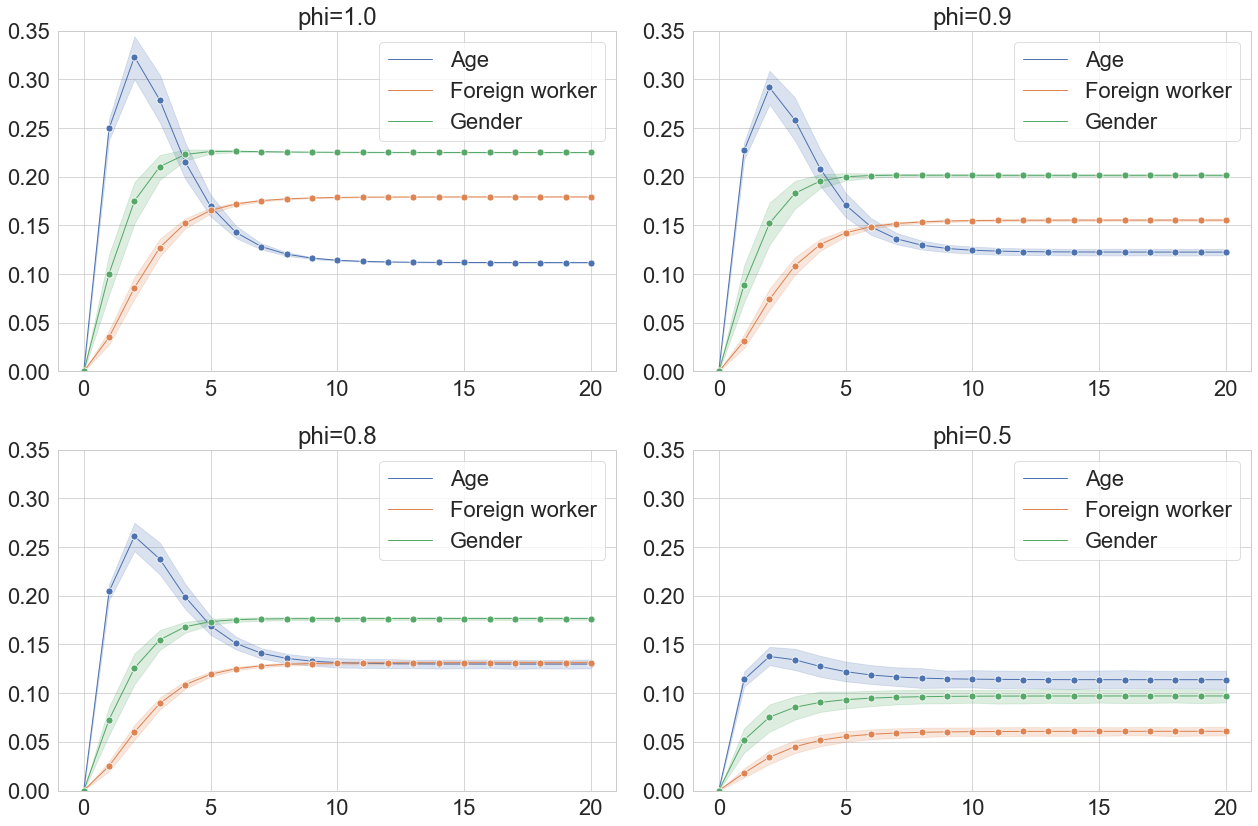

In [4]:
case = "age"
phi_values = [1.0, 0.9, 0.8, 0.5]
fig, ax= plt.subplots(2, 2, figsize=(18, 12))
grid = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f9 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f15 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, f9, 0, 0, 0, 0, f14, f15, 0, 0, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["feature"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.35])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.35)
    
    fig.tight_layout()
    plt.savefig('age.pdf')

## Scenario analysis - bias against foreign worker

We will run several scenarios to verify that the model produces reasonable results. Next, we randomly activate the variables having the largest correlation with the protected features `foreign worker`. We do this 20 times, effectively generating 20 input vectors.


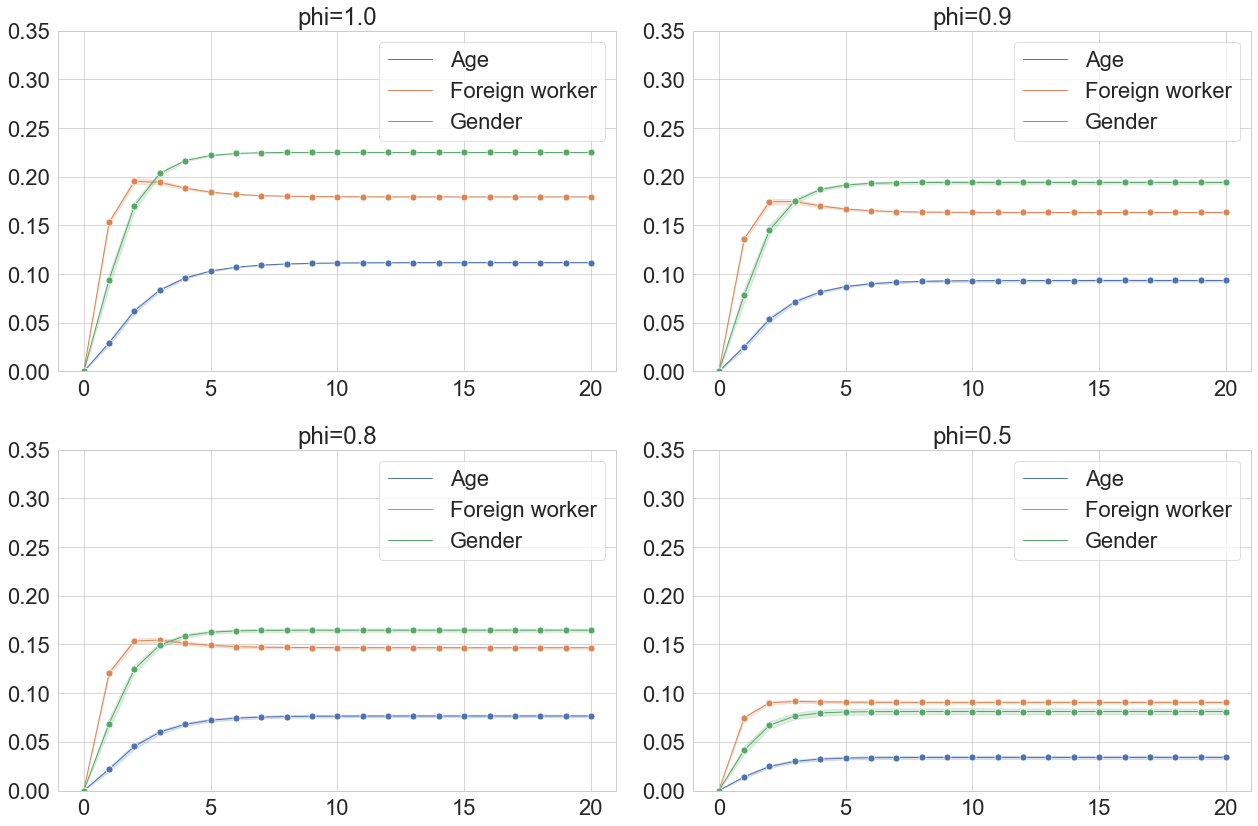

In [5]:
case = "foreign"
phi_values = [1.0, 0.9, 0.8, 0.5]
fig, ax= plt.subplots(2, 2, figsize=(18, 12))
grid = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f11 = np.random.uniform(0.0,1.0)
        f16 = np.random.uniform(0.0,1.0)
        f17 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, f11, 0, 0, 0, 0, f16, f17, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["feature"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.35])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.35)
    
    fig.tight_layout()
    plt.savefig('foreign.pdf')

## Scenario analysis - bias against gender

We will run several scenarios to verify that the model produces reasonable results. In the third scenario, we randomly activate the variables having the largest correlation with the protected features `gender`. We do this 20 times, effectively generating 20 input vectors.

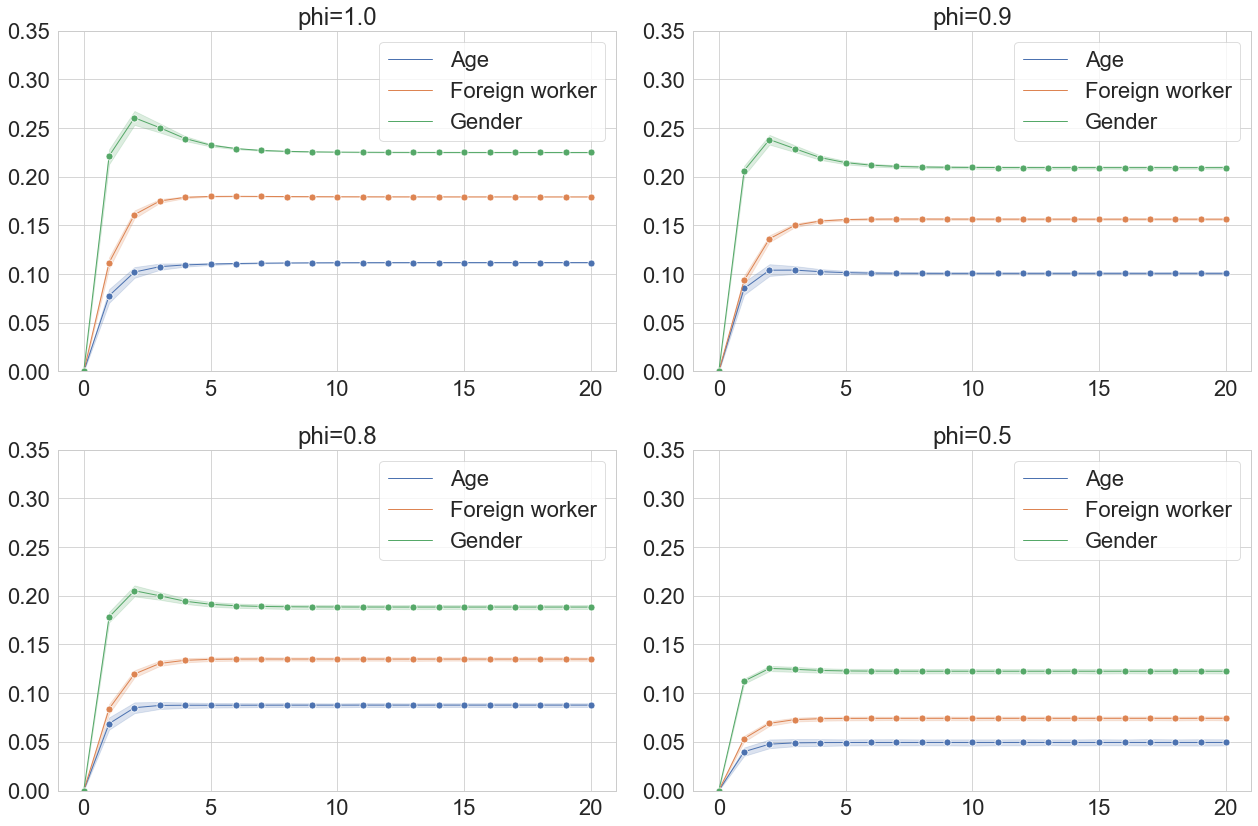

In [6]:
case = "gender"
phi_values = [1.0, 0.9, 0.8, 0.5]
fig, ax= plt.subplots(2, 2, figsize=(18, 12))
grid = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f6 = np.random.uniform(0.0,1.0)
        f10 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f17 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, f6, 0, 0, 0, f10, 0, 0, 0, f14, 0, 0, f17, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["feature"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.35])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.35)
    
    fig.tight_layout()
    plt.savefig('gender.pdf')